# Detecting Face Expressions.
## With Fast.ai

This is my exercise from [Lesson 1](https://course.fast.ai/videos/?lesson=1)

I'll use a pretrained resnet50 to classify face expressions. The face expressions I take from  http://www.kasrl.org/jaffe.html (213 images of 7 facial expressions (6 basic facial expressions + 1 neutral) posed by 10 Japanese female models):
* DI - Disgust
* SA - Sadness
* AN - Anger
* HA - Happy
* FE - Fear
* SU - Surprise
* NE - Neutral



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the fastai V1 library which sits on top of Pytorch 1.0. The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
bs = 64

In [21]:
URL = "http://www.kasrl.org/jaffedbase.zip"
path = untar_data(URL); 
print(path)
import zipfile
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall(path.parent)
zip_ref.close()
path_img = path.parent/'jaffe'

/home/jupyter/.fastai/data/jaffedbase.zip


In [22]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/home/jupyter/.fastai/data/jaffe/KM.HA4.7.tiff'),
 PosixPath('/home/jupyter/.fastai/data/jaffe/KL.SU1.164.tiff'),
 PosixPath('/home/jupyter/.fastai/data/jaffe/YM.SA1.55.tiff'),
 PosixPath('/home/jupyter/.fastai/data/jaffe/KM.AN3.19.tiff'),
 PosixPath('/home/jupyter/.fastai/data/jaffe/NM.SU2.102.tiff')]

In [24]:
np.random.seed(2)
pat = r'([A-Z]+)[0-9]\.[0-9]+\.tiff$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

Once all the data is downloaded, let's take a look to the images and see if er have the right labels, and peek at the images.

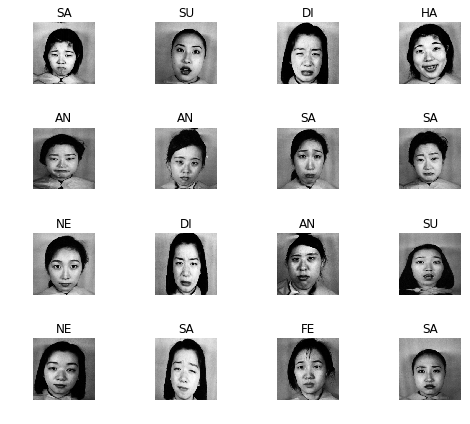

In [25]:
data.show_batch(rows=4, figsize=(7,6))

In [26]:
print(data.classes)
len(data.classes),data.c

['AN', 'DI', 'FE', 'HA', 'NE', 'SA', 'SU']


(7, 7)

Let's use a pre-trained resnet50

In [27]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


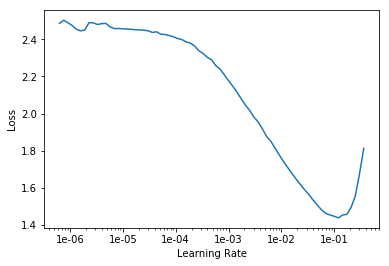

In [28]:
learn.lr_find()
learn.recorder.plot()

To start, let's train a few layer on top of our frozen resnet.

In [29]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,error_rate,time
0,2.730326,2.092592,0.880952,00:04
1,2.522791,2.015414,0.880952,00:02
2,2.375608,1.958475,0.833333,00:02
3,2.276981,1.907721,0.880952,00:02
4,2.146549,1.835007,0.785714,00:02
5,2.010633,1.785201,0.666667,00:02
6,1.941416,1.807227,0.666667,00:02
7,1.835584,1.835378,0.714286,00:02
8,1.729465,1.953485,0.714286,00:02
9,1.625816,2.141238,0.809524,00:02


**Already 16% error rate**, here the trainning loss and the validation loss are similar (sign that we are not overfitting). Really good progress.


In [30]:
learn.save('stage-1-50')

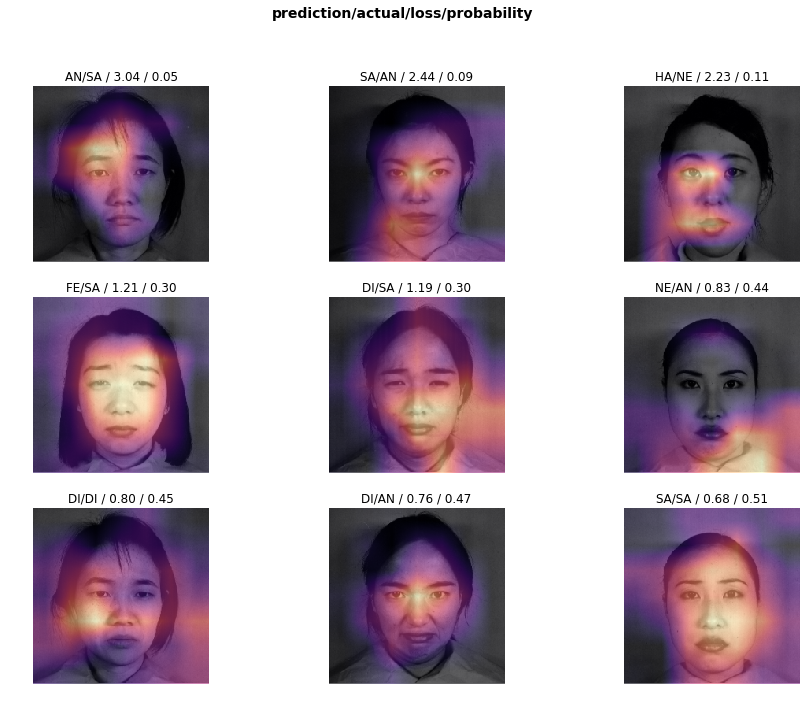

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

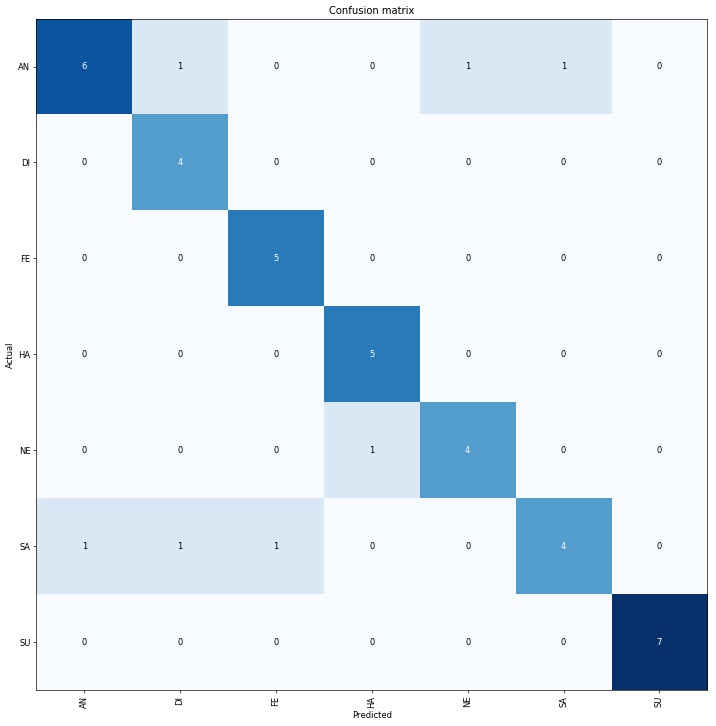

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

The heatmaps of the errors are pretty understandable, and the confussion matrix tells us that the hardest ones are Sadness and Anger. Looking at the images, it seems reasonable.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


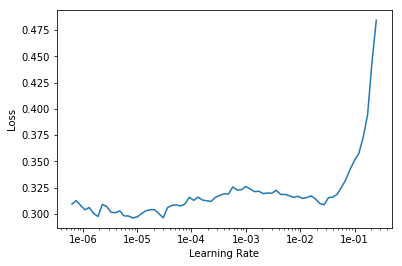

In [33]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.unfreeze()

learn.fit_one_cycle(50, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.148150,0.285289,0.095238,00:02
1,0.110470,0.298985,0.119048,00:02
2,0.091772,0.300893,0.119048,00:02
3,0.091352,0.316290,0.095238,00:02
4,0.090246,0.324427,0.095238,00:02
5,0.088530,0.345019,0.095238,00:02
6,0.090106,0.335972,0.095238,00:02
7,0.089834,0.452385,0.142857,00:02
8,0.080951,0.670366,0.166667,00:02
9,0.083367,0.622563,0.142857,00:02


The losses start to split, so I'll stop here. We have an amazing **4% error rate**, compared to the state of the art [25% from the paper in 1999](http://www.kasrl.org/michael.pdf)

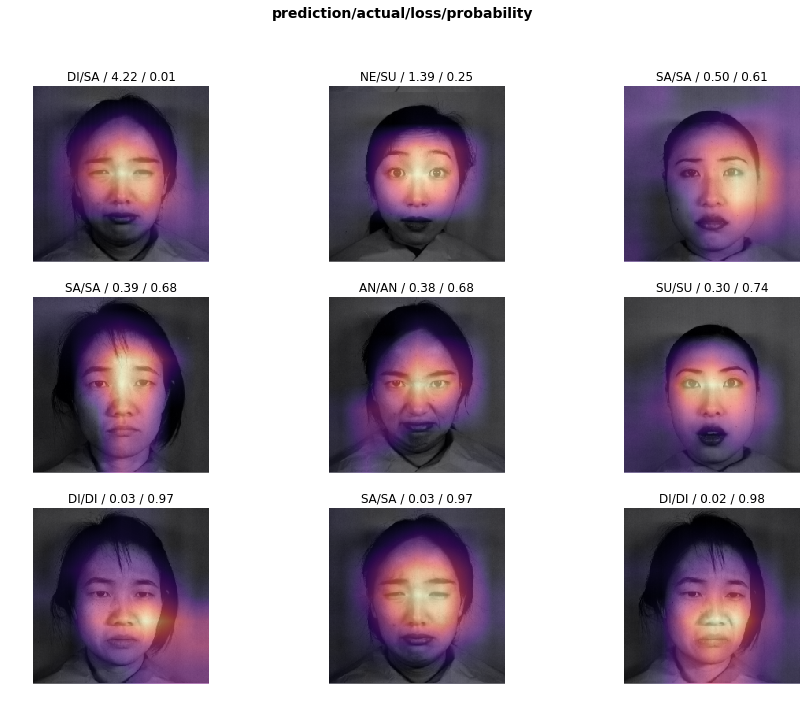

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

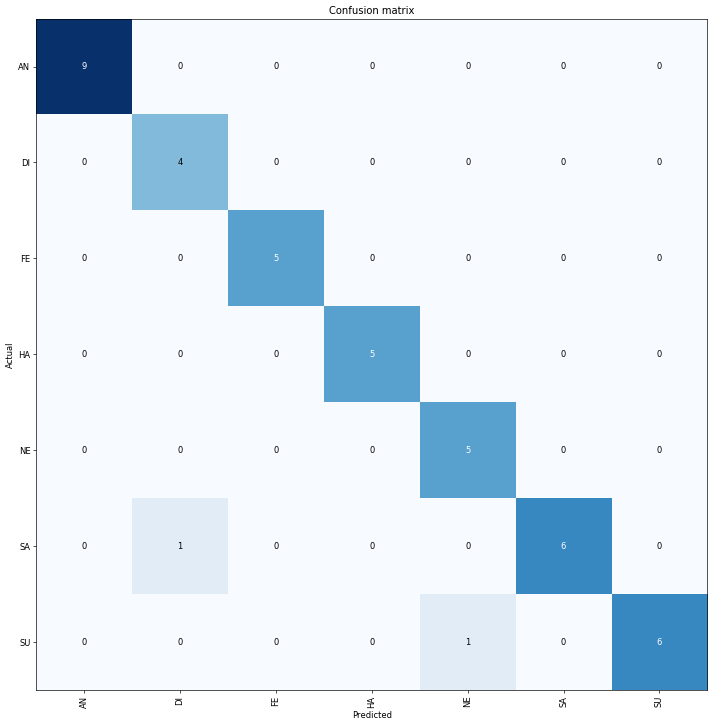

In [37]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)